# Desing of the gating strategy
This is one of the notebooks used to design the cord blood gating strategy. This is not meant to be used to actually gate the samples, but rather to see how the gates look at each step and try to determine the best approaches to gate the desired populations for each gate.

Note that the gates in this notebook may be not completely identical to those used in the final 'batch_gating.py' scirpt.

In [6]:
import aligater as ag
import pandas as pd
import numpy as np
import math as m
from styleframe import StyleFrame, utils 
from random import randint
from datetime import date
import os
import timeit

## Config
The ag.AGConfig attribute gets info from the config file. The file defines path to aligater and output path, among other things. 

In [7]:
print(ag.AGConfig.ag_home)

/home/antton/Programs/aligater/aligater


## Setup
First step is to get a list of all the .fcs files we are interested in. Once we have those, we define the "Experiment" object. It needs the filepaths to the .fcs files.

In [8]:
#Get repeats, store paths to them in 'repeats_filepaths' variable

path_to_ex = '/home/antton/TFM/data/repeats_info.xlsx'
path_to_files = "/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs" 

# # Extracting info from manually modified file
sf = StyleFrame.read_excel(path_to_ex, read_style=True, use_openpyxl_styles=False)

def only_cells_with_blue_background(cell):  # If cell has right color, give value and return. Else, leave alone.
    if cell.style.bg_color not in {utils.colors.white, '00000000'} and cell.style.bg_color not in {utils.colors.red, 'FFD9D9D9'}:
        cell.value = 'repeat'
    return cell

sf_marked = StyleFrame(sf.applymap(only_cells_with_blue_background))  # All blue cells have been noted
repeats_df = sf_marked.data_df  # DataFrame identical to the excel file with NaN for all values except for blue cells

repeats_filepaths = []  # Empty array that will contain paths to every repeat sample .fcs

for index, row in repeats_df.iterrows():  # Iterate on the DataFrame row by row
    if row.notes !='avoid' and row.notes != 'poor viability':  # Filter out crossed-out cells
        rep_locs = np.where(row.values == 'repeat')[0]  # Array with column number of blue cells
        for column_index in rep_locs:
            col_name = repeats_df.columns[column_index]  # Get actual column names (part of folder name) from index
            for folder in os.listdir(path_to_files):
                if folder.startswith(str(col_name)):  # Find the appropriate folder using the column name
                    path_into_folder = path_to_files+'/'+folder
                    for filename in os.listdir(path_into_folder):
                        if filename[3:].startswith(str(row.ID)):  # Find the specific file in folder using row ID
                            repeats_filepaths.append(path_into_folder+'/'+filename)  # Save complete filepath

/home/antton/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
/home/antton/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning:This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
/home/antton/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.


In [9]:
#Get all .fcs files before a certain date. Fuse this list with all the repeats.

path_to_files = "/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs" 
relevant_folder_paths = []
maxdate = date(2019,9,9) #last date we are interested in
all_folders = !ls ../cbio3/data/BloodVariome/Cord\ Blood/fcs  # Take ALL the folder names in 'fcs'
for folder in all_folders:  # For each subfolder
    folder_date = date(int('20'+folder[:2]),int(folder[2:4]),int(folder[4:6]))  # Take date from folder name
    if folder_date > maxdate: # If we exceed the max date, stop
        break
    relevant_folder_paths.append(path_to_files+"/"+folder)  # Add the complete path to the subfolders

genotyped_filepaths = []  # List of all filepath to input into the experiment object.
for subfolder in relevant_folder_paths:
    #ls_path = subfolder.replace(' ','/ ')
    for file in os.listdir(subfolder):
        if file.endswith('.fcs'):
            genotyped_filepaths.append(subfolder+"/"+file)
            
final_filepaths = genotyped_filepaths + list(set(repeats_filepaths) - set(genotyped_filepaths))         

print('All repeat measurements: ', len(repeats_filepaths))
print('All genotyped files: ', len(genotyped_filepaths))
print('All relevant files: ', len(final_filepaths))
n = randint(0, len(genotyped_filepaths))
print('Example filepath: ', final_filepaths[n])

#Define experiment object
exp=ag.AGExperiment(final_filepaths, \
                    filters=['fcs'], \
                    mask=['30min','45min','Neg','test'], \
                    experiment_name="my_experiment"
                   )


All repeat measurements:  559
All genotyped files:  1068
All relevant files:  1352
Example filepath:  /home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181126 CB 30-45-60min/A6 77-45min.fcs


1 filter(s) defined
4 mask(s) defined
Experiment initialised with file list. Checking entries...
All file paths exists.
Collected 1204 files, 148 files did not pass filter(s) and mask(s).


#Define experiment object
exp=ag.AGExperiment("/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs", \
                    filters=['fcs'], \
                    mask=['30min','45min','Neg','test'], \
                    experiment_name="my_experiment",
                    flourochrome_area_filter=True,
                    markers=['FSC 488/10-H',
                             'FSC 488/10-A',
                             'FSC 488/10-W',
                             'SSC 488/10-H',
                             'SSC 488/10-A',
                             'SSC 488/10-W',
                             'CD45RA FITC-A',
                             'CD8 PerCP-Cy5.5-A',
                             'CD34 PE-Cy7-A',
                             'CD235a PE-Cy5-A',
                             'CD90 PE (R-phycoerythrin)-A',
                             'CD19 PE-Texas Red-A',
                             'CD56 (BV) 650-A',
                             'CD135 (BV) 711-A',
                             'CD16 (BV) 786-A',
                             'CD38 (BV) 421-A',
                             'CD14 (BV) 605-A',
                             'CD4 (BV) 510-A',
                             'CD45 Alexa Fluor 700-A',
                             'CD3 APC-H7-A',
                             'CD10 APC (Allophycocyanin)-A']
                   )

flagged = exp.check_metadata()

In [10]:
# Select a random sample and open it
n = randint(0, 1204)
my_sample = ag.loadFCS(exp.fcsList[n], flourochrome_area_filter=True, return_type="agsample")
# Complete path to file.
exp.fcsList[n]

Opening file C8 530 from folder /fcs/190610 CB
Loaded dataset with 36037 events.


'/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/190610 CB/C8 530.fcs'

In [11]:
del(my_sample)
#target_sample =  '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/190610 CB/C7 529.fcs'
target_sample =  '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/191118 CB/A6 1092.fcs'

my_sample = ag.loadFCS(target_sample, flourochrome_area_filter=True, return_type="agsample")


Opening file A6 1092 from folder /fcs/191118 CB
Loaded dataset with 329069 events.


In [12]:
# Complete path to file.
exp.fcsList

['/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/A1 27.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/A2 28.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/A3 29.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/A4 30.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/A5 31.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/A6 32.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/A7 33.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/A8 34.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/B1 35.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/B2 36.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/B3 37.fcs',
 '/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/181029 CB 60min/B4 38.fcs',
 '/home/antton/c

In [13]:
n=1

In [14]:
#Check markers
markers = my_sample().columns.tolist()

for marker in markers[6:]:
    print(marker)
    if marker.startswith('CD45'):
        CD45 = marker
    if marker.startswith('7AAD') or marker.startswith('CD235'):
        marker_7AAD = marker
print('* * * For this sample * * *')
print('* * * CD45 marker name is: ', CD45, ' * * *')
print('* * * 7AAD marker name is: ', marker_7AAD, ' * * *')

CD45RA FITC-A
CD8 PerCP-Cy5.5-A
CD34 PE-Cy7-A
7AAD PE-Cy5-A
CD90 PE (R-phycoerythrin)-A
CD19 PE-Texas Red-A
CD56 (BV) 650-A
CD135 (BV) 711-A
CD16 (BV) 786-A
CD38 (BV) 421-A
CD14 (BV) 605-A
CD4 (BV) 510-A
CD45 Alexa 700-A
CD3 APC-H7-A
CD10 APC (Allophycocyanin)-A
* * * For this sample * * *
* * * CD45 marker name is:  CD45 Alexa 700-A  * * *
* * * 7AAD marker name is:  7AAD PE-Cy5-A  * * *


## Gate 1:  Live/Dead separation through 7AAD
**x axis:** 'FSC 488/10-A' \
**y axis:** 'CD235a PE-Cy5-A'

**Note:** 7AAD has been wrongly tagged as CD235!

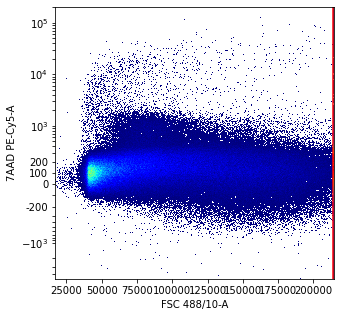

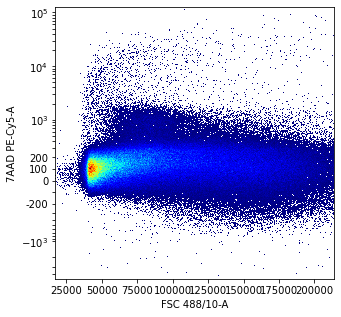

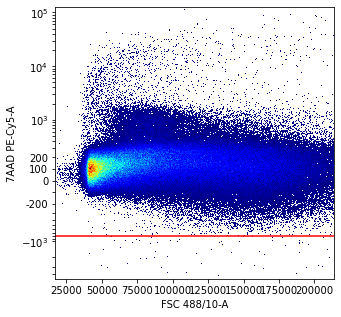

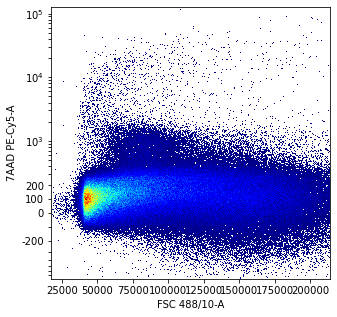

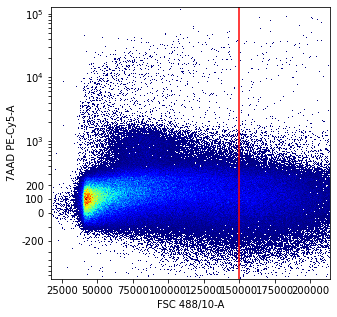

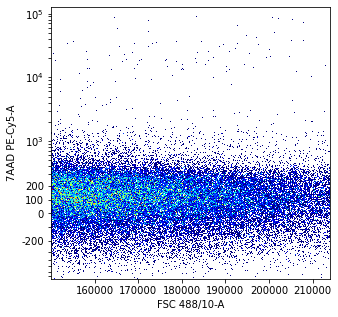

calculated ylim:  501.0758721994026
used ylim:  501.0758721994026


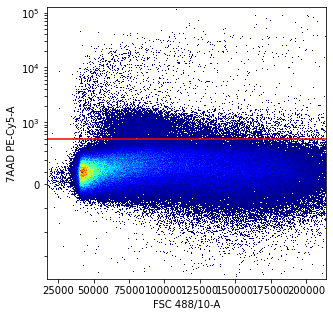

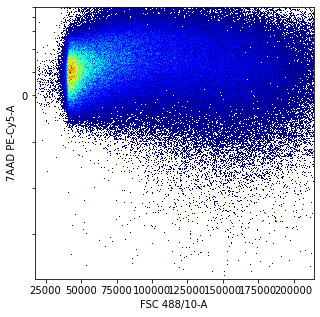

Gate #1 complete!
Total gate runtime:  5.461032858118415  seconds.


In [15]:
start = timeit.default_timer()

#Remove x-values that are too high
livedead_step1 = ag.gateThreshold(my_sample, name="remove_clutter",
                                  xCol='FSC 488/10-A', yCol= marker_7AAD, 
                                  scale='linear', T=200, yscale='bilog',
                                  thresh=214000, 
                                  parentGate=None, 
                                  orientation='vertical', population='lower')
#Remove y-values that are too low
livedead_step2 = ag.gateThreshold(my_sample, name="remove_clutter",
                                  xCol='FSC 488/10-A', yCol= marker_7AAD, 
                                  scale='linear', T=200, yscale='bilog',
                                  thresh=-800, 
                                  parentGate=livedead_step1, 
                                  orientation='horisontal', population='upper')

#Get low density point in slope of y-axis of later half
halfcut = ag.gateThreshold(my_sample, name="remove_clutter",
                                  xCol='FSC 488/10-A', yCol= marker_7AAD, 
                                  scale='linear', T=200, yscale='bilog',
                                  thresh=150000, 
                                  parentGate=livedead_step2, 
                                  orientation='vertical', population='upper')

ylim_back = ag.densityDelimitation(my_sample, xCol= marker_7AAD, parentGate=halfcut,
                                   interval=[300,1100], limit_threshold=0.2,
                                   direction='right',scale='bilog',T=200)

print('calculated ylim: ', ylim_back)
if ylim_back == m.inf:
    ylim_back = 900
print('used ylim: ', ylim_back)


livedead_step3 = ag.gateThreshold(my_sample, name="lowest_density",
                                  xCol='FSC 488/10-A', yCol= marker_7AAD, 
                                  scale='linear', T=200, yscale='logish',
                                  thresh=ylim_back, 
                                  parentGate=livedead_step2, 
                                  orientation='horisontal', population='lower')

print('Gate #1 complete!')
stop = timeit.default_timer()
print('Total gate runtime: ', stop - start, ' seconds.')

## Gate 2:  Singlets
**x axis:** 'FSC 488/10-A' \
**y axis:** 'FSC 488/10-H'

**Recommended gates:** gatePC elliptical

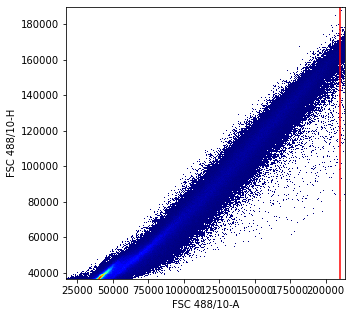

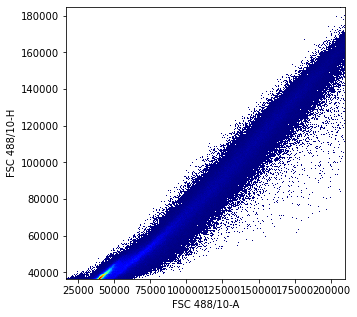

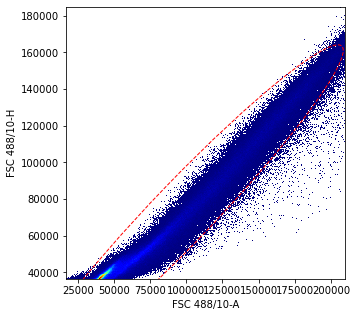

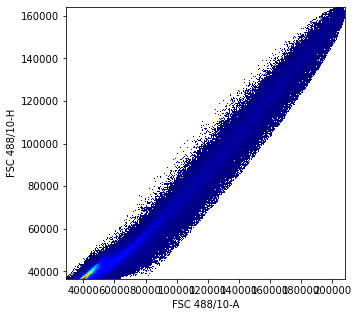

Gate #2 complete!
Total gate runtime:  2.4350769678130746  seconds.


<Figure size 360x360 with 0 Axes>

In [16]:
start = timeit.default_timer()

#Cut off high FSC values
singlets_step1 = ag.gateThreshold(my_sample, name="remove_clutter",
                                  xCol='FSC 488/10-A', yCol='FSC 488/10-H', 
                                  scale='linear', thresh=210000,
                                  parentGate=livedead_step3,  
                                  orientation='vertical', population='lower')


#PC gate
singlets = ag.gatePC(my_sample, name="PBMC",
                 xCol='FSC 488/10-A', yCol='FSC 488/10-H',
                 center='centroid', adjustAngle=3,widthScale=2.5,
                 heightScale=3.5, parentGate=singlets_step1)

print('Gate #2 complete!')
stop = timeit.default_timer()
print('Total gate runtime: ', stop - start, ' seconds.')

## Gate 3: PBMC
**x axis:** 'FSC 488/10-A' \
**y axis:** 'SSC 488/10-A'

In [17]:
##EXPERIMENTAL VERSION

# Dijkstra from side to side (shows many steps)
print('Top Cut')


ylim_bot = ag.densityDelimitation(my_sample, xCol='SSC 488/10-A', parentGate=halfcut_middle,
                                   interval=[10000,20000], limit_threshold=0.05,
                                   direction='left',scale='linear')

if ylim_bot == m.inf:
    ylim_bot = 10000

#  Cut corner
PBMC_step1 = ag.gateCorner(my_sample, name="cut_corner", xCol='FSC 488/10-A', yCol='SSC 488/10-A',
                                xThresh=85000, yThresh=ylim_bot, xOrientation='lower', yOrientation='lower',
                                Outer=True, parentGate=singlets)

# Calculte top_ylim
halfcut_tail = ag.gateThreshold(my_sample, name="right_tail",
                                  xCol='FSC 488/10-A', yCol='SSC 488/10-A', 
                                  scale='linear', thresh=180000,
                                  parentGate=singlets,  
                                  orientation='vertical', population='upper')

halfcut_middle = ag.gateThreshold(my_sample, name="right_tail",
                                  xCol='FSC 488/10-A', yCol='SSC 488/10-A', 
                                  scale='linear', thresh=120000,
                                  parentGate=singlets,  
                                  orientation='vertical', population='upper')

ylim_top = ag.densityDelimitation(my_sample, xCol='SSC 488/10-A', parentGate=halfcut_tail,
                                   interval=[50000, 125000], limit_threshold=0.2,
                                   direction='right',scale='linear') + 25000

if ylim_top == m.inf:
    ylim_top = 140000
    
PBMC_step2 = ag.horisontalPath(my_sample, name="hor_path",
                        xCol='FSC 488/10-A', yCol='SSC 488/10-A', population='lower',
                        startY=ylim_bot+30000, endY=ylim_top, xboundaries=[55000,140000],
                        yboundaries=[ylim_bot+25000,ylim_top+5000],
                        leftRight=True , direction='both',
                        maxStep=2, phi=0.1, bins=100, sigma=1,
                        scale='linear', parentGate=PBMC_step1)


ag.backGate(my_sample, population=PBMC_step2, background_population=singlets,
            xCol='FSC 488/10-A', yCol='SSC 488/10-A', scale='linear', T=200, markersize=0.1)
'''
PBMC_step2 = ag.gateTiltedLine(my_sample, name="remove_clutter_3",
               xCol='FSC 488/10-A', yCol='SSC 488/10-A',
               startPoint=(None,ylim_bot), endLimits=(None, ylim_top), theta=50,
               #scale='bilog', T=200,
               population='lower',
               parentGate=PBMC_step1)
G1 = PBMC_step2
'''
G1 = PBMC_step2


Top Cut


NameError: name 'halfcut_middle' is not defined

Top Cut


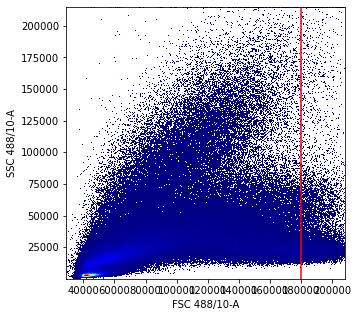

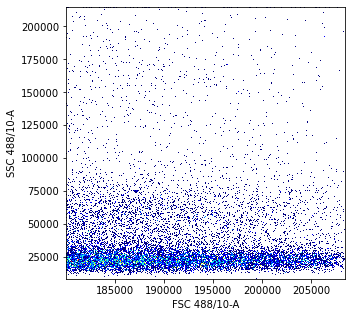

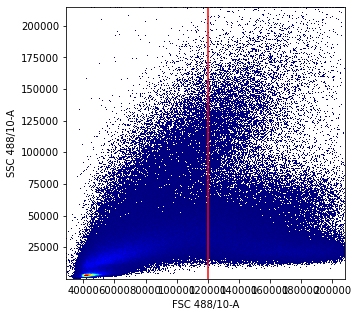

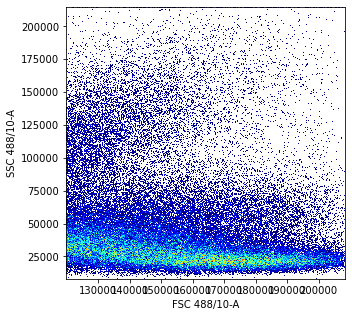

Upper y threshold:  85109.57845333334
Lower y threshold:  11530.588928000001


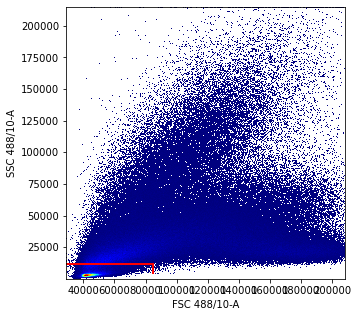

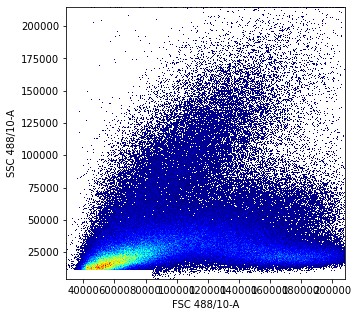

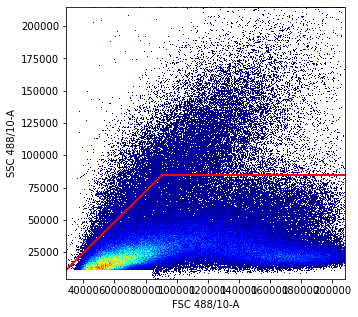

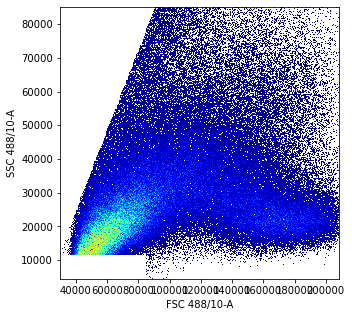

In [18]:
print('Top Cut')

#  Get ylims
halfcut_tail = ag.gateThreshold(my_sample, name="right_tail",
                                  xCol='FSC 488/10-A', yCol='SSC 488/10-A', 
                                  scale='linear', thresh=180000,
                                  parentGate=singlets,  
                                  orientation='vertical', population='upper')

halfcut_middle = ag.gateThreshold(my_sample, name="right_tail",
                                  xCol='FSC 488/10-A', yCol='SSC 488/10-A', 
                                  scale='linear', thresh=120000,
                                  parentGate=singlets,  
                                  orientation='vertical', population='upper')

ylim_top = ag.densityDelimitation(my_sample, xCol='SSC 488/10-A', parentGate=halfcut_tail,
                                   interval=[50000, 125000], limit_threshold=0.2,
                                   direction='right',scale='linear')

if ylim_top == m.inf:
    ylim_top = 140000
ylim_bot = ag.densityDelimitation(my_sample, xCol='SSC 488/10-A', parentGate=halfcut_middle,
                                   interval=[10000,20000], limit_threshold=0.05,
                                   direction='left',scale='linear')

if ylim_bot == m.inf:
    ylim_bot = 10000
print('Upper y threshold: ', ylim_top)
print('Lower y threshold: ', ylim_bot)

#  Cut corner
PBMC_step1 = ag.gateCorner(my_sample, name="cut_corner", xCol='FSC 488/10-A', yCol='SSC 488/10-A',
                                xThresh=85000, yThresh=ylim_bot, xOrientation='lower', yOrientation='lower',
                                Outer=True, parentGate=singlets)

PBMC_step2 = ag.gateTiltedLine(my_sample, name="remove_clutter_3",
               xCol='FSC 488/10-A', yCol='SSC 488/10-A',
               startPoint=(None,ylim_bot), endLimits=(None, ylim_top), theta=50,
               #scale='bilog', T=200,
               population='lower',
               parentGate=PBMC_step1)
G1 = PBMC_step2

## Gate 4B: CD3
**x axis:** 'CD45 Alexa Fluor 700-A' \
**y axis:** 'CD3 APC-H7-A'

**Logarithmic Scale!**

Step 1


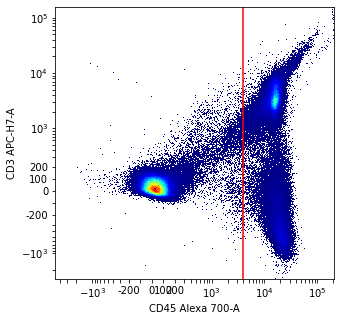

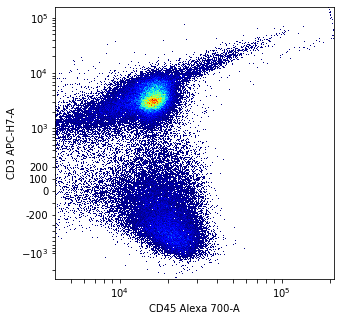

Step 2


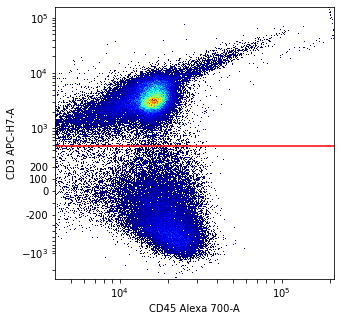

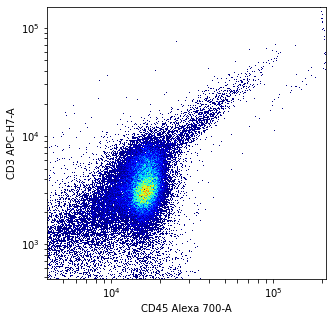

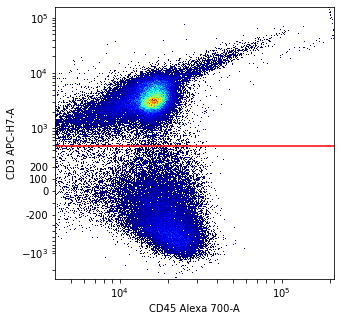

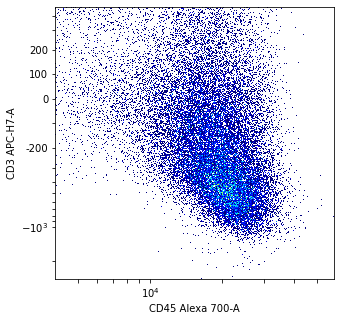

Step 3
xlim value was inf, replaced by  4000


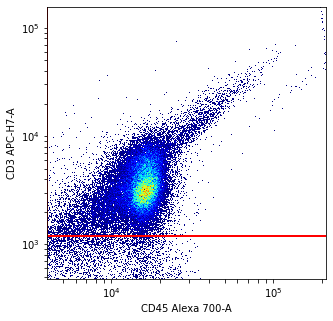

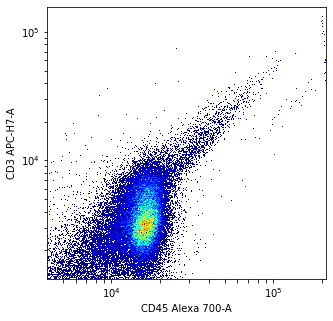

Step 4


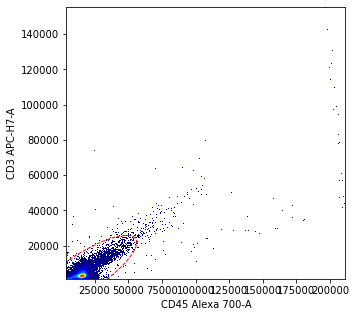

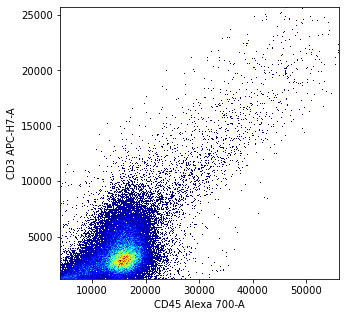

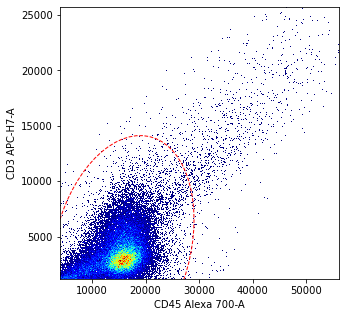

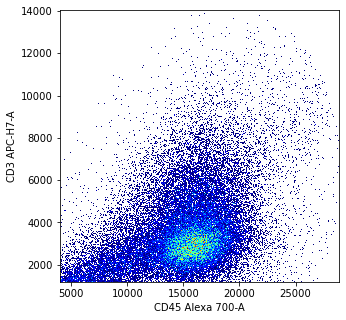

Step 5


<Figure size 360x360 with 0 Axes>

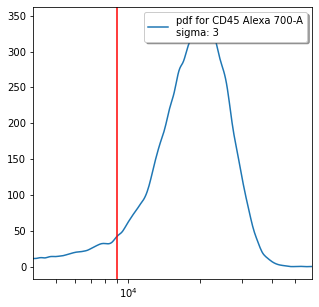

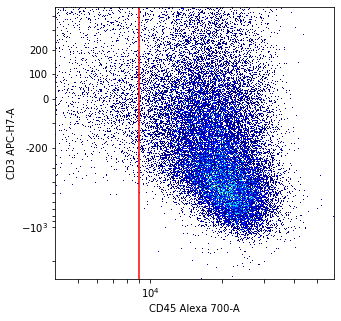

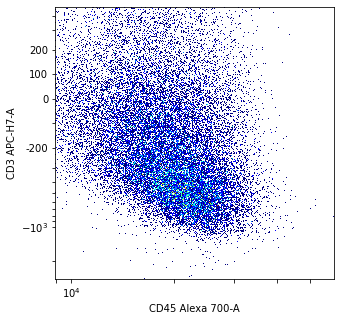

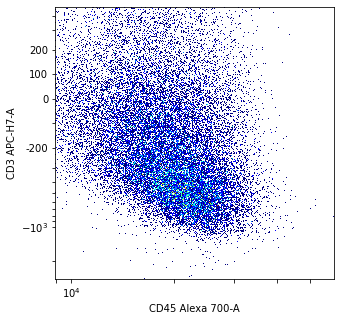

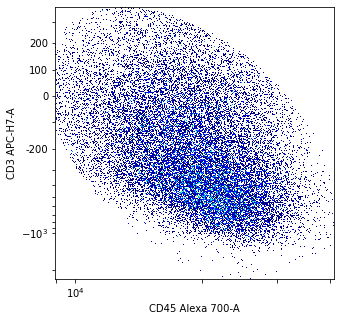

Final CD3+ population:


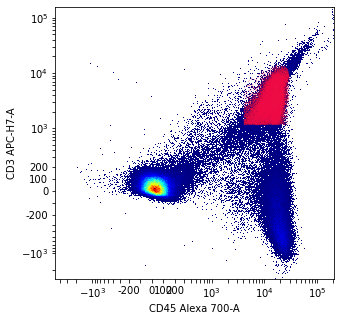

Final CD3- population:


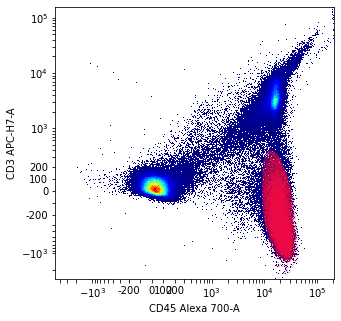

Gate #4B complete!
Total gate runtime:  6.682379611302167  seconds.


In [19]:
#ag.AGConfig.execMode='jupyter'
start = timeit.default_timer()

print('Step 1')
cd3_step1 = ag.gateThreshold(my_sample, name="rigth_side",
                                  xCol=CD45, yCol='CD3 APC-H7-A', 
                                  scale='bilog', T=200, thresh=4000,
                                  parentGate=PBMC_step2,  
                                  orientation='vertical', population='upper')

print('Step 2')
ylim_middle = ag.valleySeek(my_sample, xCol='CD3 APC-H7-A',
                    interval=[-1000, 7000], require_local_min=True,
                    scale='bilog', T=200,
                    parentGate=cd3_step1)

cd3pos_step1 = ag.gateThreshold(my_sample, name="CD3pos_cut",
                                  xCol=CD45 , yCol='CD3 APC-H7-A', 
                                  scale='bilog', T=200, thresh=ylim_middle,
                                  parentGate=cd3_step1,  
                                  orientation='horisontal', population='upper')

cd3neg_step1 = ag.gateThreshold(my_sample, name="CD3neg_step1",
                                  xCol=CD45 , yCol='CD3 APC-H7-A', 
                                  scale='bilog', T=200, thresh=ylim_middle,
                                  parentGate=cd3_step1,  
                                  orientation='horisontal', population='lower')

print('Step 3')
ylim_upper = ag.densityDelimitation(my_sample, xCol='CD3 APC-H7-A', parentGate=cd3pos_step1,
                                   interval=[800,10000], limit_threshold=0.15,
                                   direction='left', scale='bilog', T=200)
if ylim_upper == m.inf:
    ylim_upper = ylim_middle
    print('ylim value was inf, replaced by ', ylim_upper)

xlim_upper = ag.densityDelimitation(my_sample, xCol=CD45, parentGate=cd3pos_step1,
                                   interval=[800,10000], limit_threshold=0.15,
                                   direction='left', scale='bilog', T=200)
if xlim_upper == m.inf:
    xlim_upper = 4000
    print('xlim value was inf, replaced by ', xlim_upper)


cd3pos_step2 = ag.gateCorner(my_sample, name="cd3pos", xCol=CD45 , yCol='CD3 APC-H7-A',
                                xThresh=xlim_upper, yThresh=ylim_upper, xOrientation='upper', yOrientation='upper',
                                Outer=False, scale='bilog', T=200, parentGate=cd3pos_step1)

print('Step 4')
cd3pos_step3 = ag.gatePC(my_sample, name="CD3pos", xCol=CD45, yCol='CD3 APC-H7-A',
                     center='centroid', adjustAngle=3, widthScale=5,
                     heightScale=5, parentGate=cd3pos_step2)

cd3pos = ag.gatePC(my_sample, name="CD3pos", xCol=CD45, yCol='CD3 APC-H7-A',
                     center='centroid', adjustAngle=0, widthScale=2.5,
                     heightScale=5, parentGate=cd3pos_step3)

print('Step 5')
xlim_lower = ag.densityDelimitation(my_sample, xCol=CD45, parentGate=cd3pos_step1,
                                   interval=[4000,15000], limit_threshold=0.15,
                                   direction='left', scale='bilog', T=200)
if xlim_lower == m.inf:
    alternate_xlim_lower = ag.valleySeek(my_sample, xCol=CD45,
                    interval=[4000, 15000], require_local_min=True,
                    scale='bilog', T=200,
                    parentGate=cd3neg_step1)
    xlim_lower = alternate_xlim_lower
    print('xlim value was inf, replaced by ', xlim_lower)
    
cd3neg_step2 = ag.gateThreshold(my_sample, name="CD3neg_step1",
                                  xCol=CD45 ,# yCol='CD3 APC-H7-A', 
                                  scale='bilog', T=200, thresh=xlim_lower,
                                  parentGate=cd3neg_step1,  
                                  orientation='vertical', population='upper')

cd3neg_step2 = ag.gateThreshold(my_sample, name="CD3neg_step1",
                                  xCol=CD45 , yCol='CD3 APC-H7-A', 
                                  scale='bilog', T=200, thresh=xlim_lower,
                                  parentGate=cd3neg_step1,  
                                  orientation='vertical', population='upper')

cd3neg = ag.gatePC(my_sample, name="CD4pos",
                 xCol=CD45 , yCol='CD3 APC-H7-A',
                 center='centroid', adjustAngle=3, widthScale=2.5,
                 scale='bilog', T=200, heightScale=2.5,
                 parentGate=cd3neg_step2)


print('Final CD3+ population:')
ag.backGate(my_sample, population=cd3pos, background_population=PBMC_step2,
            xCol=CD45 , yCol='CD3 APC-H7-A', scale='bilog', T=200, markersize=0.1)

print('Final CD3- population:')
ag.backGate(my_sample, population=cd3neg, background_population=PBMC_step2,
            xCol=CD45 , yCol='CD3 APC-H7-A', scale='bilog', T=200, markersize=0.1)


print('Gate #4B complete!')
stop = timeit.default_timer()
print('Total gate runtime: ', stop - start, ' seconds.')

## Gate 5B1a: CD4+ out of CD3+
**x axis:** 'CD4 (BV) 510-A' \
**y axis:** 'CD8 PerCP-Cy5.5-A'



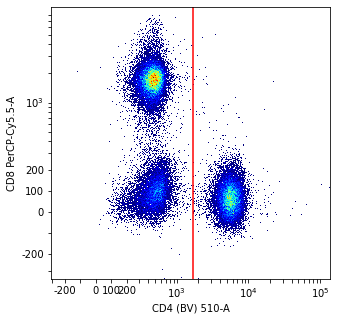

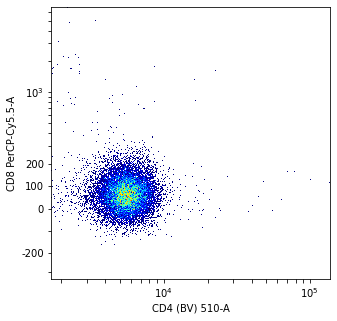

Final population, CD4 positives:


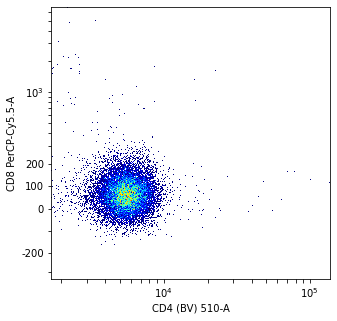

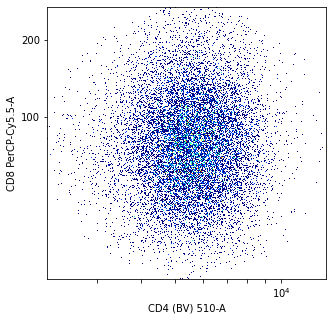

Gate 5B1a complete!
Total gate runtime:  0.951333899050951  seconds.


<Figure size 360x360 with 0 Axes>

In [20]:
start = timeit.default_timer()

xlim_middle = ag.valleySeek(my_sample, xCol='CD4 (BV) 510-A',
                    interval=[1000, 5000], require_local_min=True,
                    scale='bilog', T=200,
                    parentGate=cd3pos)

cd4cd8_step1 = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A', 
                                  scale='bilog', T=200, thresh=xlim_middle,
                                  parentGate=cd3pos,  
                                  orientation='vertical', population='upper')

print('Final population, CD4 positives:')
CD4pos_final = ag.gatePC(my_sample, name="CD4pos",
                 xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A',
                 center='centroid', adjustAngle=3,widthScale=2.5,
                 scale='bilog', T=200, heightScale=3.5,
                 parentGate=cd4cd8_step1)


'''
#HOW TO STORE GATES:
# way 1, change parent to relevant parent gate, then call update
print(CD4plus76_5.parentName)
CD4plus76_5.changeParent(cd3_step2)
print(CD4plus76_5.parentName)

my_sample.update(ag.AGgate(CD4plus76_5, cd3_step2, xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A',name="CD4pos"), )
'''

print('Gate 5B1a complete!')
stop = timeit.default_timer()
print('Total gate runtime: ', stop - start, ' seconds.')

## Gate 5B1b: CD8+ out of CD3+
**x axis:** 'CD4 (BV) 510-A' \
**y axis:** 'CD8 PerCP-Cy5.5-A'

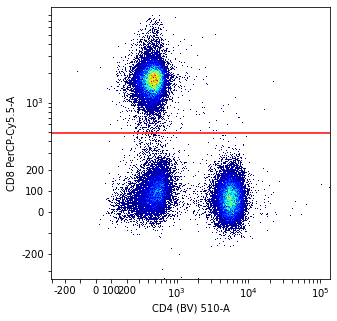

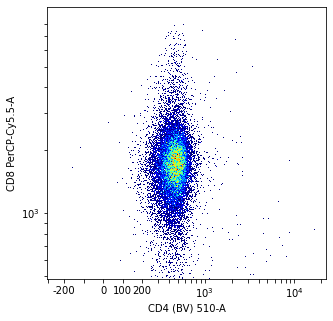

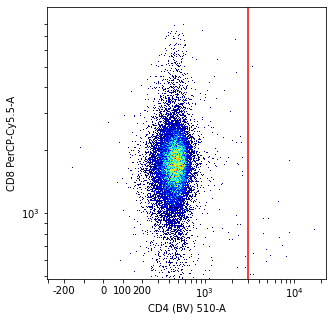

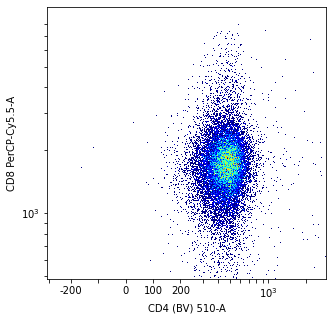

Final population, CD8 positives:


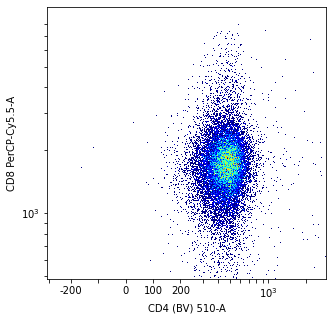

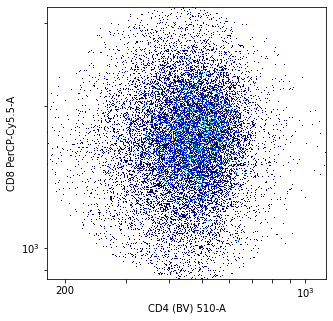

Gate 5B1b complete!
Total gate runtime:  1.463223687838763  seconds.


<Figure size 360x360 with 0 Axes>

In [21]:
start = timeit.default_timer()

ylim_middle = ag.valleySeek(my_sample, xCol='CD8 PerCP-Cy5.5-A',
                    interval=[200, 2000], require_local_min=True,
                    parentGate=cd3pos)

cd4cd8_step2 = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A', 
                                  scale='bilog', T=200, thresh=ylim_middle,
                                  parentGate=cd3pos,  
                                  orientation='horisontal', population='upper')

xlim_middle_upper = ag.valleySeek(my_sample, xCol='CD4 (BV) 510-A',
                    interval=[1000, 5000], require_local_min=True,
                    scale='bilog', T=200,
                    parentGate=cd4cd8_step2)

cd4cd8_step3 = ag.gateThreshold(my_sample, name="separate_middle_x_axis",
                                  xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A', 
                                  scale='bilog', T=200, thresh=xlim_middle_upper,
                                  parentGate=cd4cd8_step2,  
                                  orientation='vertical', population='lower')

print('Final population, CD8 positives:')
CD8pos_final = ag.gatePC(my_sample, name="CD8pos",
                 xCol='CD4 (BV) 510-A' , yCol='CD8 PerCP-Cy5.5-A',
                 center='centroid', adjustAngle=0,widthScale=2,
                 scale='bilog', T=200, heightScale=3.5,
                 parentGate=cd4cd8_step3)

print('Gate 5B1b complete!')
stop = timeit.default_timer()
print('Total gate runtime: ', stop - start, ' seconds.')

## Gate 5B2a: CD19+ out of CD3-
**x axis:** 'CD3 APC-H7-A' \
**y axis:** 'CD19 PE-Texas Red-A'

**Logarithmic Scale!**

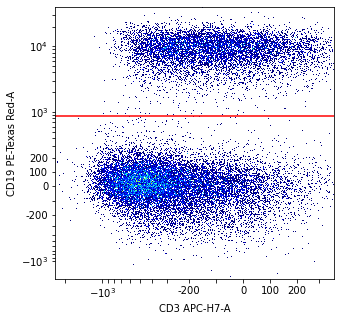

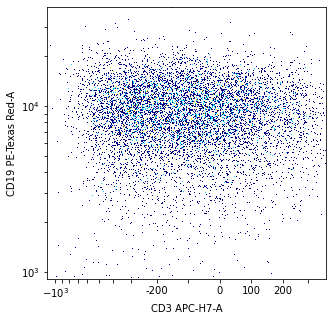

Final population, CD19 positives:


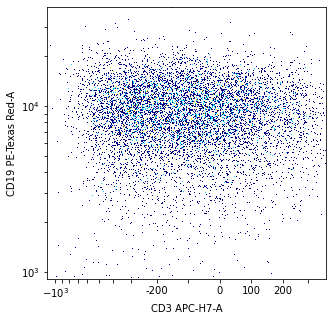

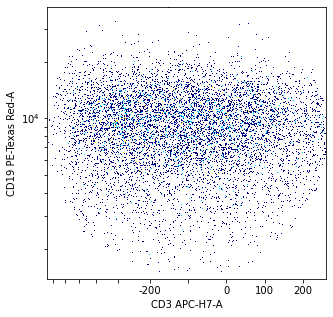

Gate 5B2a complete!
Total gate runtime:  0.859781838953495  seconds.


<Figure size 360x360 with 0 Axes>

In [22]:
start = timeit.default_timer()


ylim_middle_cd19 = ag.valleySeek(my_sample, xCol='CD19 PE-Texas Red-A',
                    interval=[200, 10000], require_local_min=True,
                    scale='bilog', T=200,
                    parentGate=cd3neg)

CD19pos_step1 = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD3 APC-H7-A',
                                  yCol='CD19 PE-Texas Red-A', 
                                  scale='bilog', T=200, thresh=ylim_middle_cd19,
                                  parentGate=cd3neg,  
                                  orientation='horisontal', population='upper')

print('Final population, CD19 positives:')
CD19pos_final = ag.gatePC(my_sample, name="CD19pos",
                 xCol='CD3 APC-H7-A' , yCol='CD19 PE-Texas Red-A',
                 center='centroid', adjustAngle=0,widthScale=2,
                 scale='bilog', T=200, heightScale=3.5,
                 parentGate=CD19pos_step1)

print('Gate 5B2a complete!')
stop = timeit.default_timer()
print('Total gate runtime: ', stop - start, ' seconds.')

## Gate 5B2b: CD19- out of CD3-
**x axis:** 'CD3 APC-H7-A' \
**y axis:** 'CD19 PE-Texas Red-A'

**Logarithmic Scale!**

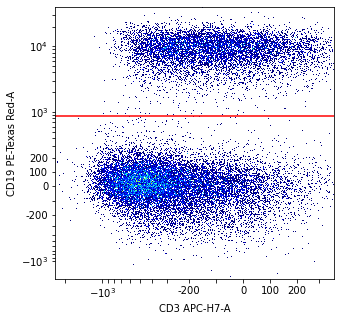

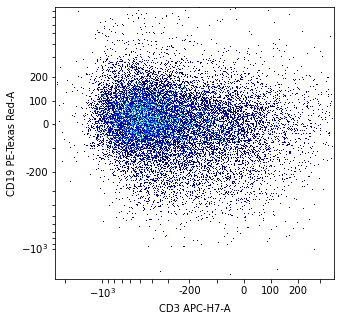

Gate 5B2b complete!
Total gate runtime:  0.47117114905267954  seconds.


In [23]:
start = timeit.default_timer()

CD19neg = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD3 APC-H7-A' , yCol='CD19 PE-Texas Red-A', 
                                  scale='bilog', T=200, thresh=ylim_middle_cd19,
                                  parentGate=cd3neg,  
                                  orientation='horisontal', population='lower')

'''
CD19neg = ag.gatePC(my_sample, name="CD19neg",
                 xCol='CD3 APC-H7-A' , yCol='CD19 PE-Texas Red-A',
                 center='centroid', adjustAngle=0,widthScale=2,
                 scale='bilog', T=200, heightScale=3.5,
                 parentGate=CD19neg_step1)
'''
print('Gate 5B2b complete!')
stop = timeit.default_timer()
print('Total gate runtime: ', stop - start, ' seconds.')

## Gate 6B2a: CD14+ out of CD19- 
**x axis:** 'CD19 PE-Texas Red-A' \
**y axis:** 'CD14 (BV) 605-A'

**Logarithmic Scale!**

836.0262271172995


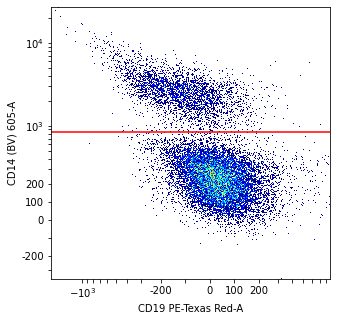

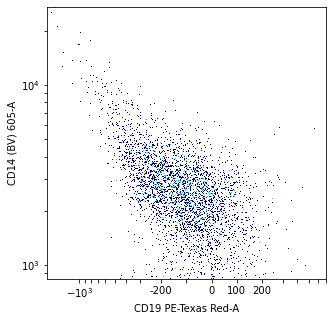

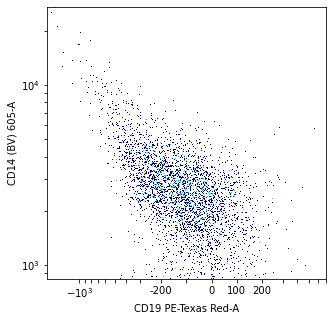

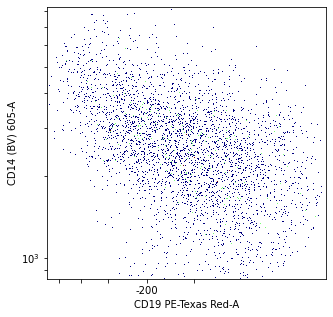

Gate 6B2a complete!
Total gate runtime:  0.9005698626860976  seconds.


<Figure size 360x360 with 0 Axes>

In [24]:
start = timeit.default_timer()

ylim_middle_cd14 = ag.valleySeek(my_sample, xCol='CD14 (BV) 605-A',
                    interval=[0, 3000], require_local_min=True,
                    parentGate=CD19neg, scale='bilog')

print(ylim_middle_cd14)

CD14pos_step1 = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD19 PE-Texas Red-A', yCol='CD14 (BV) 605-A', 
                                  scale='bilog', T=200, thresh=ylim_middle_cd14,
                                  parentGate=CD19neg,  
                                  orientation='horisontal', population='upper')

# Unsure about this one, as it usually cuts off the left tip
CD14pos = ag.gatePC(my_sample, name="CD14pos",
                 xCol='CD19 PE-Texas Red-A' , yCol='CD14 (BV) 605-A',
                 center='centroid', adjustAngle=0,widthScale=2,
                 scale='bilog', T=200, heightScale=3.5,
                 parentGate=CD14pos_step1)

print('Gate 6B2a complete!')
stop = timeit.default_timer()
print('Total gate runtime: ', stop - start, ' seconds.')

## Gate 6B2b: CD14- out of CD19-
**x axis:** 'CD34 PE-Cy7-A' \
**y axis:** 'CD45 Alexa Fluor 700-A'

**Logarithmic Scale!**

836.0262271172995


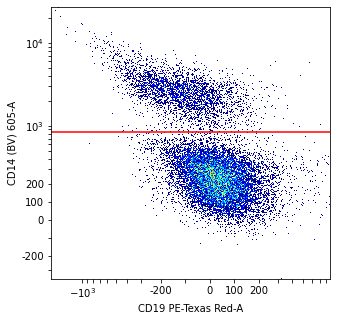

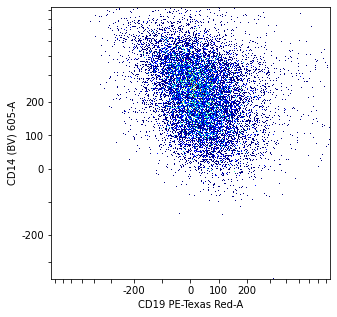

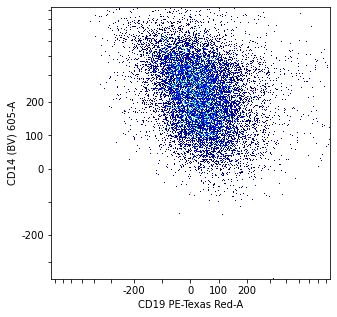

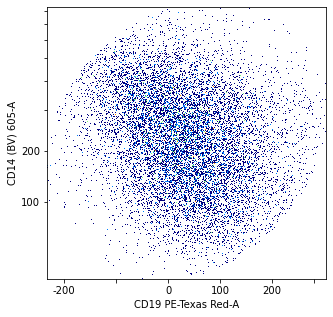

Gate 6B2a complete!
Total gate runtime:  0.7834320804104209  seconds.


<Figure size 360x360 with 0 Axes>

In [25]:
start = timeit.default_timer()



print(ylim_middle_cd14)

CD14neg_step1 = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD19 PE-Texas Red-A', yCol='CD14 (BV) 605-A', 
                                  scale='bilog', T=200, thresh=ylim_middle_cd14,
                                  parentGate=CD19neg,  
                                  orientation='horisontal', population='lower')



CD14neg = ag.gatePC(my_sample, name="CD14pos",
                 xCol='CD19 PE-Texas Red-A' , yCol='CD14 (BV) 605-A',
                 center='centroid', adjustAngle=0,widthScale=2,
                 scale='bilog', T=200, heightScale=3.5,
                 parentGate=CD14neg_step1)

print('Gate 6B2a complete!')
stop = timeit.default_timer()
print('Total gate runtime: ', stop - start, ' seconds.')

## Gate 7B2a: CD16++ and CD56++ out of CD14-
**x axis:** 'CD16 (BV) 786-A' \
**y axis:** 'CD56 (BV) 650-A'

**Logarithmic Scale!**

Step 1


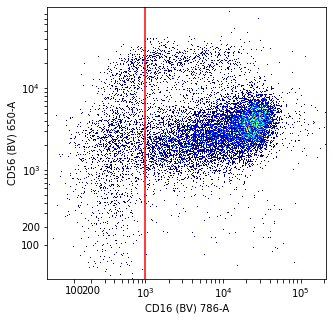

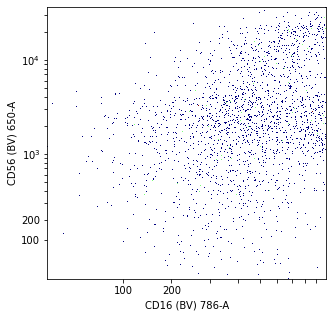

Step 2


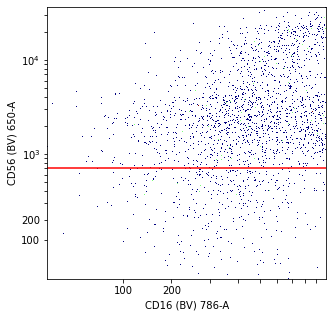

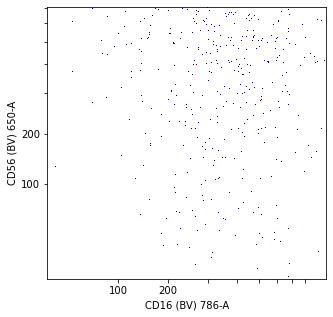

Step 3
*inf* value overwritten
Comparison between aprox_ylim_middle 713.3821626867054  and main_ylim_middle 713.3821626867054
Step 4


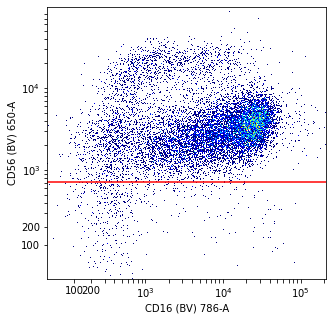

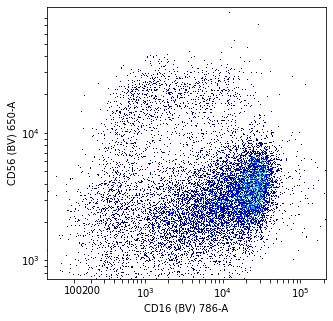

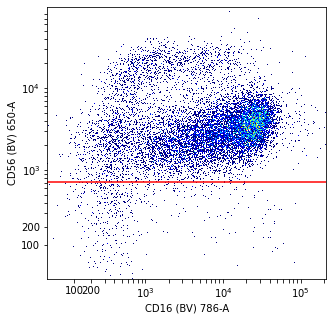

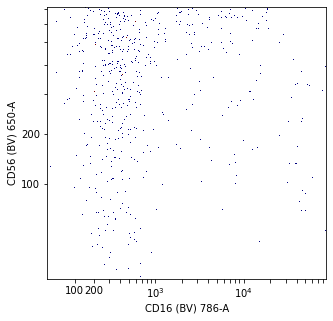

Step 5
Comparison between aprox_xlim_middle  1001.3201201113974  and approx_xlim_middle2  4962.526859544905


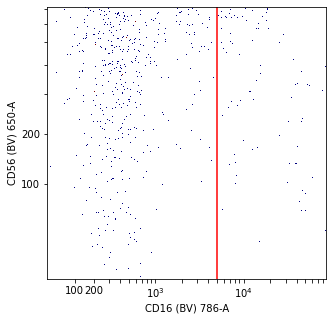

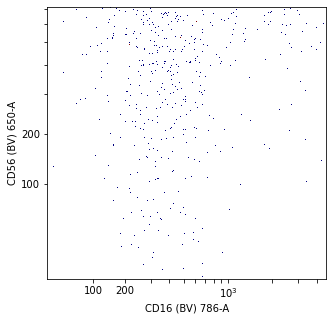

Step 6
Step 7


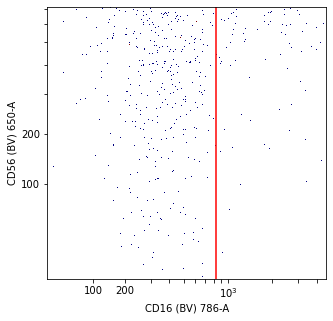

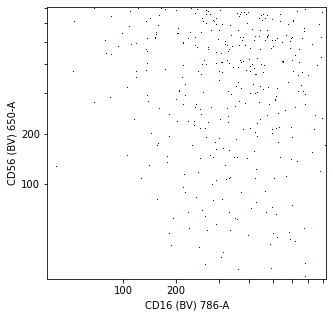

Final population, CD16 negative, CD56 negatives:


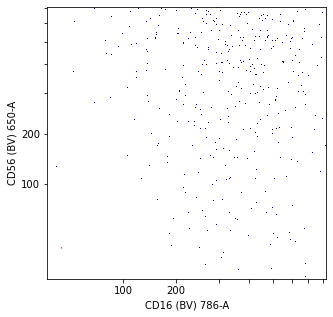

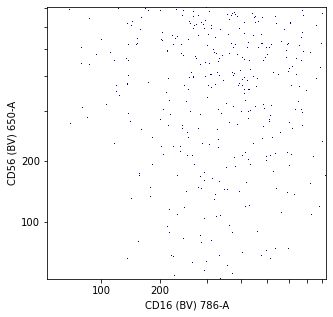

Final population, CD16++, CD56 negatives:


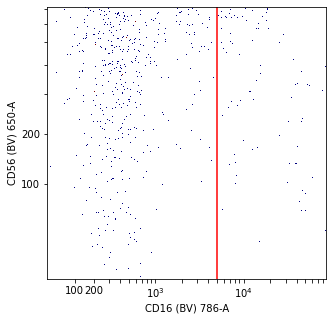

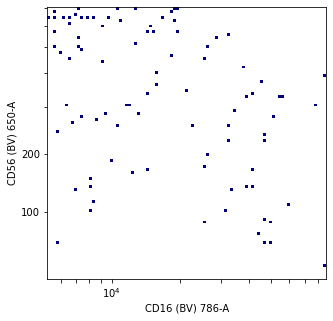

Step 8


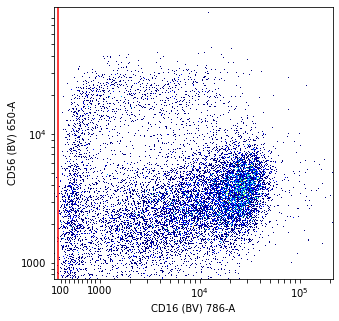

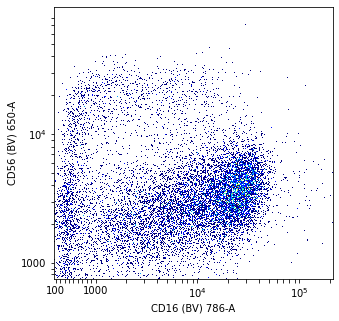

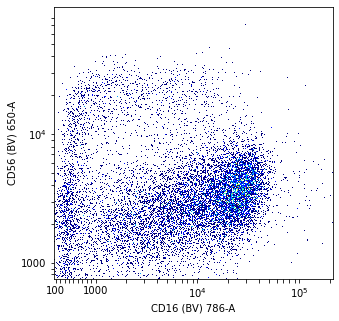

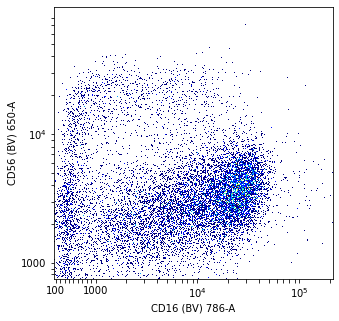

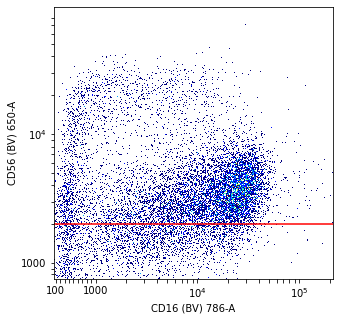

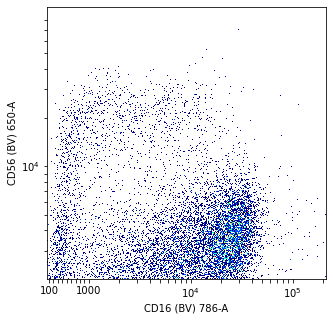

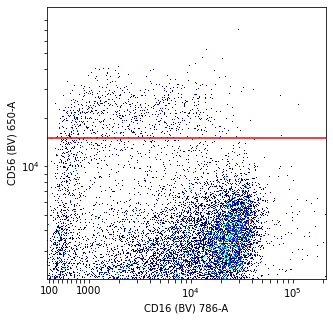

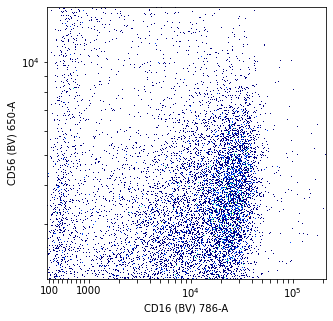

<Figure size 360x360 with 0 Axes>

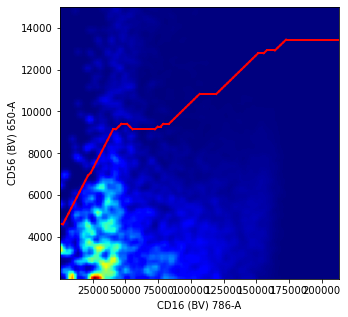

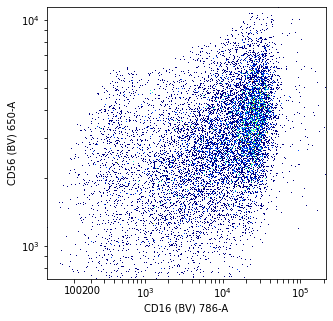

Final population, CD16-, CD56+:


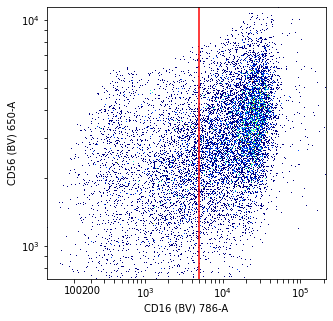

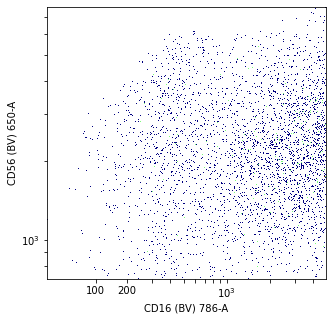

Final population, CD16+, CD56+:


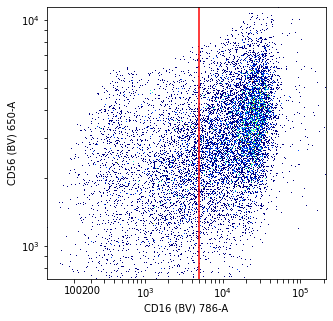

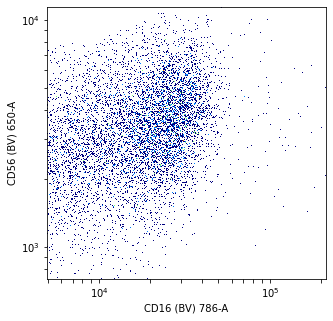

Final population, CD16-, CD56++:


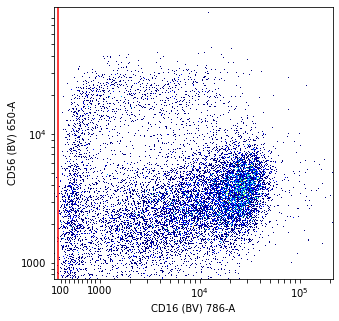

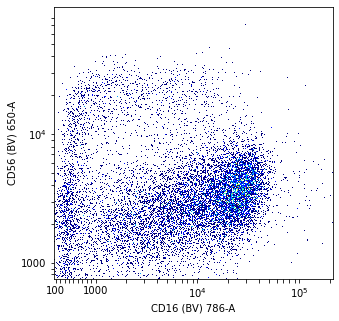

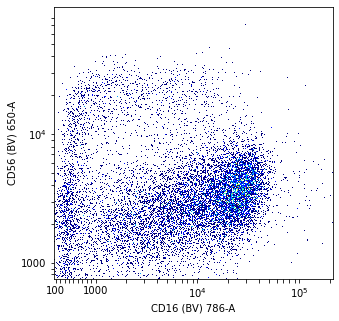

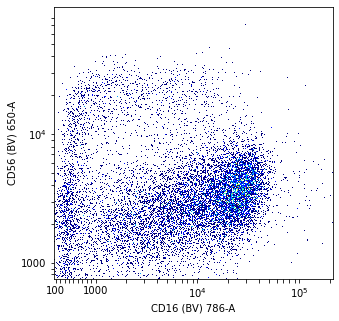

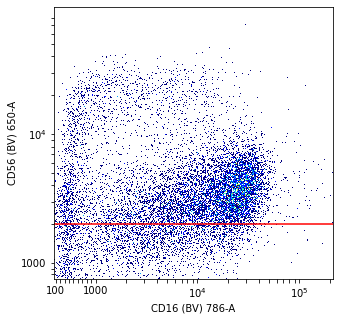

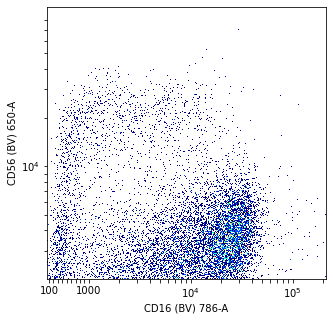

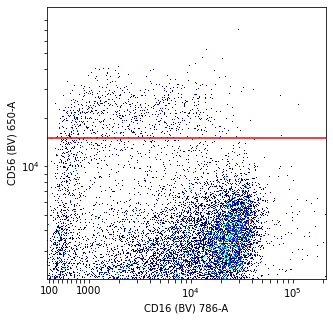

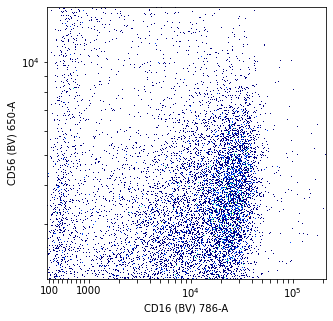

<Figure size 360x360 with 0 Axes>

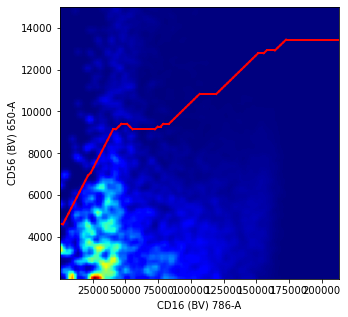

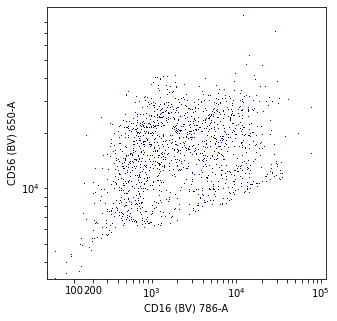

Final CD16-,CD56++ population:


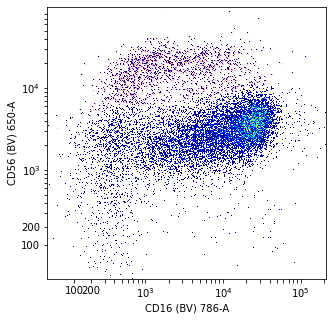

Final CD16++,CD56++ population:


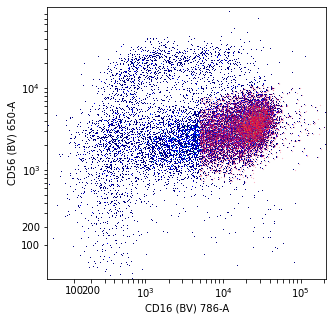

Final CD16-,CD56+ population:


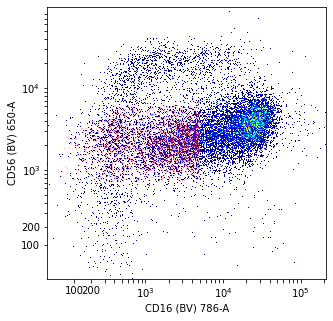

Final CD16-,CD56- population:


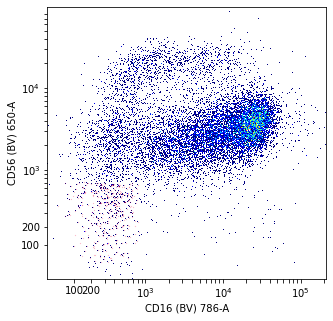

Final CD16++,CD56- population:


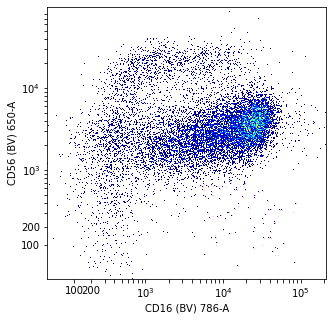

Gate 7B2a complete!
Total gate runtime:  10.84398345509544  seconds.


In [26]:
start = timeit.default_timer()

print('Step 1')
aprox_xlim_middle = ag.valleySeek(my_sample, xCol='CD16 (BV) 786-A',
                    interval=[900, 18000], require_local_min=True,
                    scale='bilog', T=200,
                    parentGate=CD14neg_step1)

left_half = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', 
                                  scale='bilog', T=200, thresh=aprox_xlim_middle,
                                  parentGate=CD14neg_step1,  
                                  orientation='vertical', population='lower')

print('Step 2')
aprox_ylim_middle = ag.valleySeek(my_sample, xCol='CD56 (BV) 650-A',
                    interval=[700, 1300], require_local_min=True,
                    scale='bilog', T=200,
                    parentGate=CD14neg_step1)

lower_left_half = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', 
                                  scale='bilog', T=200, thresh=aprox_ylim_middle,
                                  parentGate=left_half,  
                                  orientation='horisontal', population='lower')

print('Step 3')
main_ylim_middle = ag.densityDelimitation(my_sample, xCol='CD56 (BV) 650-A', parentGate=lower_left_half,
                                   interval=[0,2000], limit_threshold=0.07,
                                   direction='right',scale='linear')

if main_ylim_middle == m.inf:
    main_ylim_middle = aprox_ylim_middle
    print('*inf* value overwritten')

print('Comparison between aprox_ylim_middle', aprox_ylim_middle, ' and main_ylim_middle', main_ylim_middle)

print('Step 4')
upper_half = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', 
                                  scale='bilog', T=200, thresh=main_ylim_middle,
                                  parentGate=CD14neg_step1,  
                                  orientation='horisontal', population='upper')

lower_half = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', 
                                  scale='bilog', T=200, thresh=main_ylim_middle,
                                  parentGate=CD14neg_step1,  
                                  orientation='horisontal', population='lower')

print('Step 5')

aprox_xlim_middle2 = ag.valleySeek(my_sample, xCol='CD16 (BV) 786-A',
                    interval=[900, 18000], require_local_min=True,
                    scale='bilog', T=200,
                    parentGate=lower_half)

print('Comparison between aprox_xlim_middle ', aprox_xlim_middle, ' and approx_xlim_middle2 ', aprox_xlim_middle2)

CD16neg_56neg_step1 = ag.gateThreshold(my_sample, name="lower_left_side",
                                  xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', 
                                  scale='bilog', T=200, thresh=aprox_xlim_middle2,
                                  parentGate=lower_half,  
                                  orientation='vertical', population='lower')

print('Step 6')


main_xlim_middle = ag.densityDelimitation(my_sample, xCol='CD16 (BV) 786-A', parentGate=CD16neg_56neg_step1,
                                   interval=[0,2000], limit_threshold=0.07,
                                   direction='right',scale='linear')

if main_xlim_middle == m.inf:
    main_xlim_middle = aprox_xlim_middle
    print('*inf* value overwritten for main xlim')
    
main_xlim_left = ag.densityDelimitation(my_sample, xCol='CD16 (BV) 786-A', parentGate=CD16neg_56neg_step1,
                                   interval=[0,1000], limit_threshold=0.07,
                                   direction='left',scale='linear')

if main_xlim_left == m.inf:
    main_xlim_left = 150
    print('*inf* value overwritten for left xlim')

print('Step 7')

CD16neg_56neg_step2 = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', 
                                  scale='bilog', T=200, thresh=main_xlim_middle,
                                  parentGate=CD16neg_56neg_step1,  
                                  orientation='vertical', population='lower')

print('Final population, CD16 negative, CD56 negatives:')
CD16neg_56neg_final = ag.gatePC(my_sample, name="CD16neg_56neg",
                 xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A',
                 center='centroid', adjustAngle=0,widthScale=2,
                 scale='bilog', T=200, heightScale=3.5,
                 parentGate=CD16neg_56neg_step2)

print('Final population, CD16++, CD56 negatives:')
CD16pospos_56neg_final = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', 
                                  scale='bilog', T=200, thresh=aprox_xlim_middle2,
                                  parentGate=lower_half,  
                                  orientation='vertical', population='upper')

print('Step 8')
central_section = ag.horisontalPath(my_sample, name="hor_path",
                        xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', population='lower',
                        startY=3000, endY=12000,
                        xboundaries=[main_xlim_left,500000],
                        yboundaries=[2000,15000],
                        leftRight=True , direction='both',
                        maxStep=2, phi=0.1, bins=100, sigma=1,
                        scale='bilog', T=200, parentGate=upper_half)

print('Final population, CD16-, CD56+:')
CD16neg_56pos_final = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', 
                                  scale='bilog', T=200, thresh=aprox_xlim_middle2,
                                  parentGate=central_section,  
                                  orientation='vertical', population='lower')

print('Final population, CD16+, CD56+:')
CD16pospos_56pospos_final = ag.gateThreshold(my_sample, name="separate_middle",
                                  xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', 
                                  scale='bilog', T=200, thresh=aprox_xlim_middle2,
                                  parentGate=central_section,  
                                  orientation='vertical', population='upper')

print('Final population, CD16-, CD56++:')
CD16neg_56pospos = ag.horisontalPath(my_sample, name="hor_path",
                        xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', population='upper',
                        startY=3000, endY=12000, xboundaries=[main_xlim_left,500000],
                        yboundaries=[2000,15000],
                        leftRight=True , direction='both',
                        maxStep=2, phi=0.1, bins=100, sigma=1,
                        scale='bilog', T=200, parentGate=upper_half)

print('Final CD16-,CD56++ population:')
ag.backGate(my_sample, population=CD16neg_56pospos, background_population=CD14neg_step1,
            xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, markersize=0.1)

print('Final CD16++,CD56++ population:')
ag.backGate(my_sample, population=CD16pospos_56pospos_final, background_population=CD14neg_step1,
            xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, markersize=0.1)

print('Final CD16-,CD56+ population:')
ag.backGate(my_sample, population=CD16neg_56pos_final, background_population=CD14neg_step1,
            xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, markersize=0.1)

print('Final CD16-,CD56- population:')
ag.backGate(my_sample, population=CD16neg_56neg_final, background_population=CD14neg_step1,
            xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, markersize=0.1)

print('Final CD16++,CD56- population:')
ag.backGate(my_sample, population=CD16pospos_56neg_final, background_population=CD14neg_step1,
            xCol='CD16 (BV) 786-A' , yCol='CD56 (BV) 650-A', scale='bilog', T=200, markersize=0.1)


print('Gate 7B2a complete!')
stop = timeit.default_timer()
print('Total gate runtime: ', stop - start, ' seconds.')

In [28]:
vX, vY = ag.getGatedVectors(my_sample(), gate1='CD16 (BV) 786-A', gate2='CD56 (BV) 650-A', vI=upper_half())

In [29]:
vX

11        22774.475369
50          958.167735
58           78.945144
64        23771.094050
151         697.608595
              ...     
328952     3809.084485
328958     2662.289336
329039    33476.938989
329062    14611.931254
329063      307.833718
Name: CD16 (BV) 786-A, Length: 13860, dtype: float64

In [24]:
vY

16         1593.664468
25         1843.783393
34         2167.643948
81         1074.076291
115        6401.886899
              ...     
2547809    6140.409334
2547836     904.028753
2547856    2654.908125
2547857    2076.348288
2547859    8655.516019
Name: CD56 (BV) 650-A, Length: 170736, dtype: float64

## Gate 8B2: 

**x axis:** 'CD34 PE-Cy7-A' \
**y axis:** 'CD45 Alexa Fluor 700-A'

in valleySeek: Local min requested, but none found. Returning infinity.


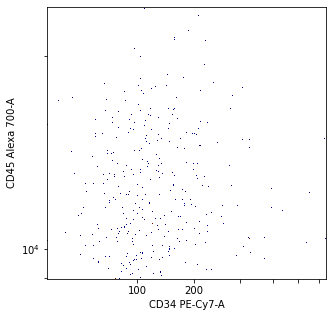

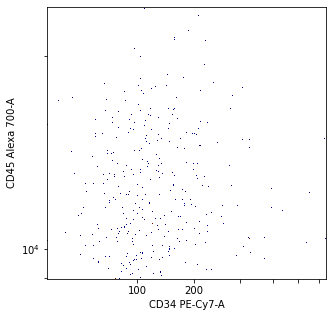

In [30]:
xlim_cd34 = ag.valleySeek(my_sample, xCol='CD34 PE-Cy7-A',
                    interval=[800, 8000], require_local_min=True,
                    scale='bilog', T=200,
                    parentGate=CD16neg_56neg_final)

left_half = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD34 PE-Cy7-A' , yCol=CD45, 
                                  scale='bilog', T=200, thresh=xlim_cd34,
                                  parentGate=CD16neg_56neg_final,  
                                  orientation='vertical', population='lower')

## Gate 4A: CD34+ and CD45+ out of PBMCs
**x axis:** 'CD34 PE-Cy7-A' \
**y axis:** 'CD45 Alexa Fluor 700-A'

**Logarithmic Scale!**

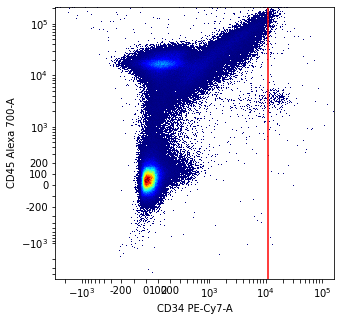

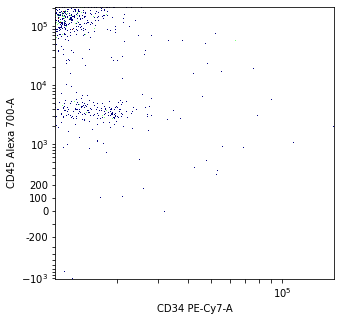

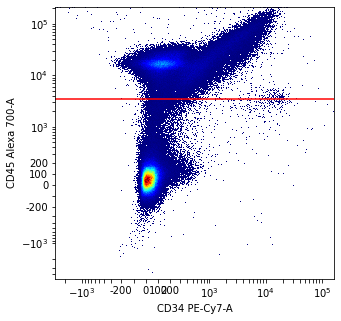

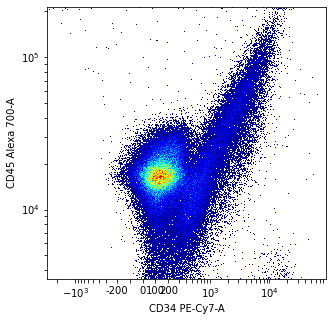

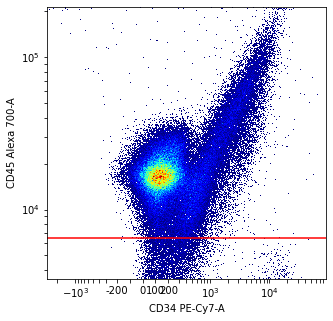

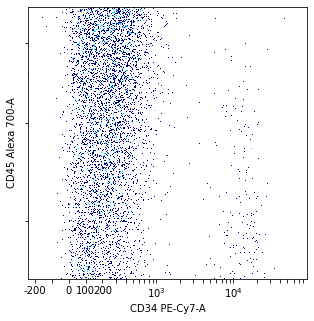

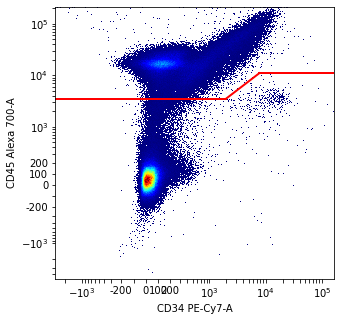

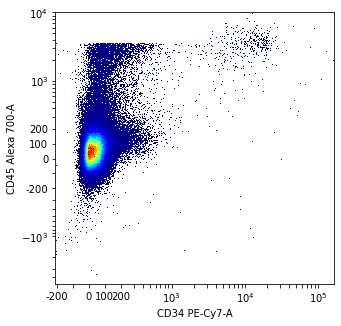

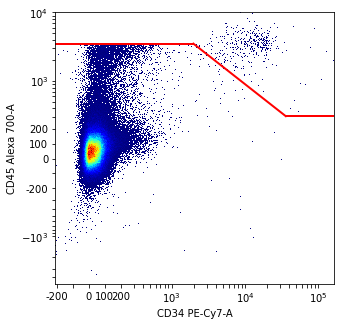

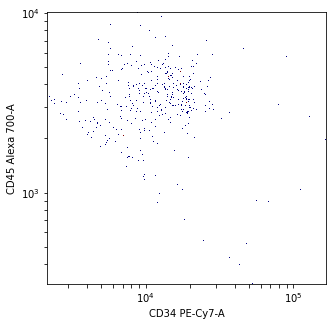

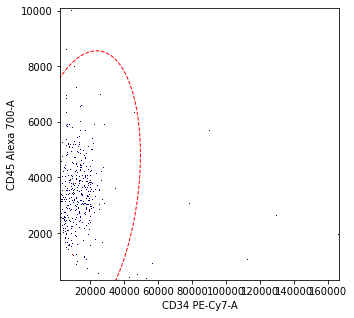

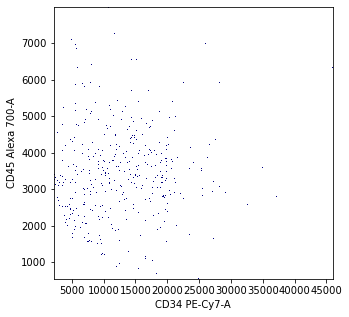

<Figure size 360x360 with 0 Axes>

In [31]:
start = timeit.default_timer()

xlim_arbitrary = 11000

right_half = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD34 PE-Cy7-A' , yCol=CD45, 
                                  scale='bilog', T=200, thresh=xlim_arbitrary,
                                  parentGate=singlets,  
                                  orientation='vertical', population='upper')

mean, median, sigma, maxVal = ag.axisStats(my_sample(), xCol=CD45, vI=right_half())

upper_half = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD34 PE-Cy7-A', 
                                  yCol=CD45, 
                                  scale='bilog', T=200, thresh=maxVal,
                                  parentGate=singlets,  
                                  orientation='horisontal', population='upper')

lowr_halfof_upper_half = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD34 PE-Cy7-A', 
                                  yCol=CD45, 
                                  scale='bilog', T=200, thresh=maxVal+3000,
                                  parentGate=upper_half,  
                                  orientation='horisontal', population='lower')

xlim_middle = ag.valleySeek(my_sample, xCol='CD34 PE-Cy7-A',
                    interval=[800, 11000], require_local_min=True,
                    scale='bilog', T=200, parentGate=lowr_halfof_upper_half) -1000

CD34_step1 = ag.gateTiltedLine(my_sample, name="remove_clutter_3",
               xCol='CD34 PE-Cy7-A' , yCol=CD45,
               startPoint=(xlim_middle,maxVal), endLimits=(None, maxVal+7500), theta=40,
               scale='bilog', T=200, population='lower',
               parentGate=singlets)

CD34_step2 = ag.gateTiltedLine(my_sample, name="remove_clutter_3",
               xCol='CD34 PE-Cy7-A' , yCol=CD45,
               startPoint=(xlim_middle,maxVal), endLimits=(None, maxVal-3200), theta=-40,
               scale='bilog', T=200, population='upper',
               parentGate=CD34_step1)

CD34_45pos = ag.gatePC(my_sample, name="CD34",
                 xCol='CD34 PE-Cy7-A' , yCol=CD45,
                 center='centroid', adjustAngle=3,widthScale=2.5,
                 heightScale=3.5, parentGate=CD34_step2)

## Gate 5A: CD38+ and CD38-
**x axis:** 'CD34 PE-Cy7-A' \
**y axis:** 'CD38 (BV) 421-A'

**Logarithmic Scale!**

580.718064119487


<Figure size 360x360 with 0 Axes>

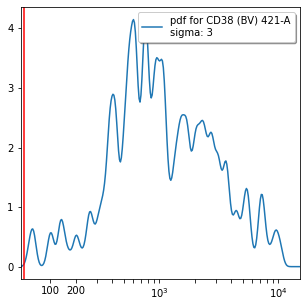

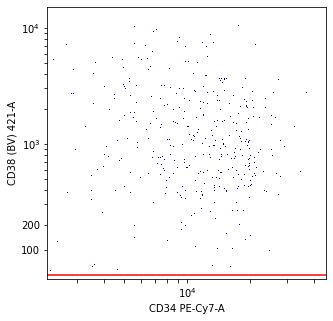

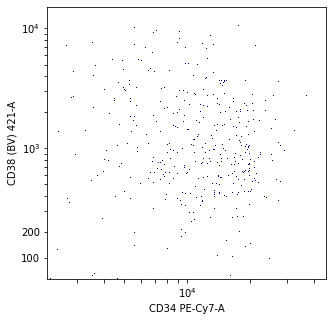

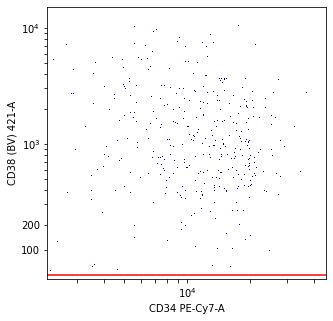

Passed index contains no events


<Figure size 360x360 with 0 Axes>

total events:  432
events above threshold: 431, 0.9976851851851852 percent
events below threshold: 1, 0.0023148148148148147 percent
Runtime for CD38 gate:  0.7065681628882885


In [32]:
start = timeit.default_timer()

density = True

if density:
    highest_density_coords = ag.getHighestDensityPoint(my_sample, xCol='CD34 PE-Cy7-A',
                                    yCol='CD38 (BV) 421-A',
                                    parentGate=CD34_45pos,
                                    scale='bilog', T=200)

    ylim_middle = highest_density_coords[1]
    #if ylim_middle > 850:
        #ylim_middle = 850
    #lim_middle -= 300  
else:
    gated_df = my_sample.fcsDF.loc[CD34_45pos()].copy()
    cd38_values_list = sorted(list(gated_df['CD38 (BV) 421-A']))
    index = int(len(cd38_values_list)*0.3)
    ylim_middle = cd38_values_list[index]
    
    
print(ylim_middle)
ylim_middle = 0

CD38pos_2d = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  #xCol='CD34 PE-Cy7-A' ,
                                  xCol='CD38 (BV) 421-A', 
                                  scale='bilog', T=200, thresh=ylim_middle,
                                  parentGate=CD34_45pos,  
                                  orientation='vertical', population='upper')

#Actual gate (for now)
CD38pos = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD34 PE-Cy7-A' ,
                                  yCol='CD38 (BV) 421-A', 
                                  scale='bilog', T=200, thresh=ylim_middle,
                                  parentGate=CD34_45pos,  
                                  orientation='horisontal', population='upper')

CD38neg = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD34 PE-Cy7-A' , yCol='CD38 (BV) 421-A', 
                                  scale='bilog', T=200, thresh=ylim_middle,
                                  parentGate=CD34_45pos,  
                                  orientation='horisontal', population='lower')

#ag.backGate(my_sample, population=high_CD90_values, background_population=CD34_45pos,
#            xCol='CD34 PE-Cy7-A'  , yCol='CD38 (BV) 421-A', scale='bilog', T=200, markersize=0.9)

print('total events: ', len(CD34_45pos()))
print('events above threshold: '+str(len(CD38pos()))+ ', '+str(len(CD38pos())/len(CD34_45pos()))+' percent')
print('events below threshold: '+str(len(CD38neg()))+ ', '+str(len(CD38neg())/len(CD34_45pos()))+' percent')

stop = timeit.default_timer()
print('Runtime for CD38 gate: ', stop - start)

In [53]:
start = timeit.default_timer()

input_gate = CD38neg

print('Number of events: ', len(input_gate()))
ylim = ag.densityDelimitation(my_sample, xCol='CD90 PE (R-phycoerythrin)-A',
                                   interval=[200,5000], limit_threshold=0.5,
                                   direction='right',scale='bilog',T=200,
                                   parentGate=input_gate)

xlim = ag.densityDelimitation(my_sample, xCol='CD45RA FITC-A',
                                   interval=[-100,300], limit_threshold=0.05,
                                   direction='right',scale='bilog',T=200,
                                   parentGate=input_gate)

if ylim == m.inf:
    print('Trying plan B...')
    right_hand= ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD45RA FITC-A',
                                  yCol='CD90 PE (R-phycoerythrin)-A', 
                                  scale='bilog', T=200, thresh=xlim,
                                  parentGate=input_gate,  
                                  orientation='vertical', population='upper')
    
    ylim = ag.densityDelimitation(my_sample, xCol='CD90 PE (R-phycoerythrin)-A',
                                   interval=[200,5000], limit_threshold=0.2,
                                   direction='right',scale='bilog',T=200,
                                   parentGate=right_hand)
    if ylim == m.inf:
        print('Trying plan C...')
        ylim = 5000

print(ylim)
print(xlim)


HSC, irrelevant, MLP, MPP = ag.quadGate(my_sample, names=['HSC', 'irrelevant', 'MLP', 'MPP'],
                                       xCol='CD45RA FITC-A', yCol='CD90 PE (R-phycoerythrin)-A',
                                       xThresh=xlim, yThresh=ylim,
                                       scale='bilog', T=200,
                                       parentGate=input_gate)

print('Gate 6A2 complete!')
stop = timeit.default_timer()
print('Complete runtime: ', stop - start)

Number of events:  1
2600.0
100.0
Gate 6A2 complete!
Complete runtime:  0.0008232039399445057


WARNING, in valleySeek: Passed index contains too few events, defaulting to mid-interval
WARNING, in valleySeek: Passed index contains too few events, defaulting to mid-interval


#Plotting CD38 with every other marker to look for correlations or clusters
for marker in my_sample().columns.tolist():
    print(marker)
    CD38pos_experiment= ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol=marker ,
                                  yCol='CD38 (BV) 421-A', 
                                  scale='bilog', T=200, thresh=ylim_middle,
                                  parentGate=CD34_45pos,  
                                  orientation='horisontal', population='upper')
CD90_CD45= ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD90 PE (R-phycoerythrin)-A' ,
                                  yCol='CD45 Alexa Fluor 700-A', 
                                  scale='bilog', T=200, thresh=ylim_middle,
                                  parentGate=CD34_45pos,  
                                  orientation='horisontal', population='upper')

## Gate 6A1a: non-NK (CD10neg) out of CD38pos
**x axis:** 'CD45RA FITC-A' \
**y axis:** 'CD10 APC (Allophycocyanin)-A'

**Logarithmic Scale!**

In [50]:
start = timeit.default_timer()

ylim_back = ag.densityDelimitation(my_sample, xCol='CD10 APC (Allophycocyanin)-A', parentGate=halfcut,
                                   interval=[-100,800], limit_threshold=0.2,
                                   direction='right',scale='bilog',T=200)

BNK_prog = ag.gateCorner(my_sample, name="BNK", xCol='CD45RA FITC-A', yCol='CD10 APC (Allophycocyanin)-A',
                                xThresh=200, yThresh=ylim_back, xOrientation='upper', yOrientation='upper',
                                Outer=False, scale='bilog', T=200, parentGate=CD38pos)

nonNK= ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD45RA FITC-A',
                                  yCol='CD10 APC (Allophycocyanin)-A', 
                                  scale='bilog', T=200, thresh=ylim_back,
                                  parentGate=CD38pos,  
                                  orientation='horisontal', population='lower')

stop = timeit.default_timer()
print('Runtime for linear: ', stop - start)

NameError: name 'CD38pos' is not defined

## Gate 6A1b: CMPs, GMPs and MEPs out of non-NK (CD10-), CD38+
**x axis:** 'CD45RA FITC-A' \
**y axis:** 'CD135 (BV) 711-A'

**Logarithmic Scale!**

184.73305746626184
132.93297128939145


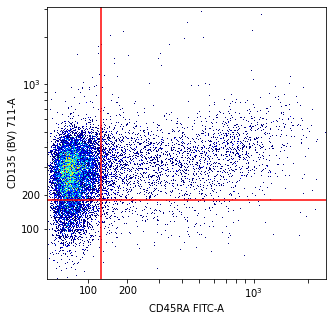

Gate 6A1a complete!
Complete runtime:  0.24446954694576561


In [30]:
start = timeit.default_timer()

ylim = ag.densityDelimitation(my_sample, xCol='CD135 (BV) 711-A',
                                   interval=[-100,800], limit_threshold=0.5,
                                   direction='left',scale='bilog',T=200,
                                   parentGate=nonNK)

xlim_cut_tail = ag.densityDelimitation(my_sample, xCol='CD45RA FITC-A',
                                   interval=[-100,800], limit_threshold=0.2,
                                   direction='right',scale='bilog',T=200,
                                   parentGate=nonNK)

print(ylim)
print(xlim_cut_tail)

CMP, GMP, irrelevant, MEP = ag.quadGate(my_sample, names=['Th1', 'Th2', 'Th1_Th17', 'Th17'],
                                       xCol='CD45RA FITC-A', yCol='CD135 (BV) 711-A',
                                       xThresh=xlim_cut_tail, yThresh=ylim,
                                       scale='bilog', T=200,
                                       parentGate=nonNK)

print('Gate 6A1a complete!')
stop = timeit.default_timer()
print('Complete runtime: ', stop - start)

## Gate 6A2: HSCs, MPPs and MLPs out of CD38-
**x axis:** 'CD45RA FITC-A' \
**y axis:** 'CD90 PE (R-phycoerythrin)-A'

**Logarithmic Scale!**

In [31]:
start = timeit.default_timer()

ylim = ag.densityDelimitation(my_sample, xCol='CD90 PE (R-phycoerythrin)-A',
                                   interval=[200,5000], limit_threshold=0.5,
                                   direction='right',scale='bilog',T=200,
                                   parentGate=CD38neg)

xlim = ag.densityDelimitation(my_sample, xCol='CD45RA FITC-A',
                                   interval=[-100,300], limit_threshold=0.05,
                                   direction='right',scale='bilog',T=200,
                                   parentGate=CD38neg)

if ylim == m.inf:
    print('Trying plan B...')
    right_hand= ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD45RA FITC-A',
                                  yCol='CD90 PE (R-phycoerythrin)-A', 
                                  scale='bilog', T=200, thresh=xlim,
                                  parentGate=CD38neg,  
                                  orientation='vertical', population='upper')
    
    ylim = ag.densityDelimitation(my_sample, xCol='CD90 PE (R-phycoerythrin)-A',
                                   interval=[200,5000], limit_threshold=0.2,
                                   direction='right',scale='bilog',T=200,
                                   parentGate=right_hand)
    if ylim == m.inf:
        print('Trying plan C...')
        ylim = 5000

print(ylim)
print(xlim)


HSC, irrelevant, MLP, MPP = ag.quadGate(my_sample, names=['HSC', 'irrelevant', 'MLP', 'MPP'],
                                       xCol='CD45RA FITC-A', yCol='CD90 PE (R-phycoerythrin)-A',
                                       xThresh=xlim_cut_tail, yThresh=ylim,
                                       scale='bilog', T=200,
                                       parentGate=CD38neg)

print('Gate 6A2 complete!')
stop = timeit.default_timer()
print('Complete runtime: ', stop - start)

2600.0
100.0
Gate 6A2 complete!
Complete runtime:  0.0007097388152033091


WARNING, in valleySeek: Passed index contains too few events, defaulting to mid-interval
WARNING, in valleySeek: Passed index contains too few events, defaulting to mid-interval


In [32]:
ag.backGate(my_sample, population=HSC, background_population=CD34_45pos,
            xCol='CD34 PE-Cy7-A'  , yCol='CD38 (BV) 421-A', scale='bilog', T=200, markersize=0.5)

WARNING, in backGate: Passed population (HSC) contains no events


## Gate 7A2: CD10+ out of MLPs
**x axis:** 'CD45RA FITC-A' \
**y axis:** 'CD10 APC (Allophycocyanin)-A'

**Logarithmic Scale!**

In [33]:
start = timeit.default_timer()

#ylim_back defines CD10 pos/neg in gate 6A1
CD10pos_MLP = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                  xCol='CD45RA FITC-A',
                                  yCol='CD10 APC (Allophycocyanin)-A', 
                                  scale='bilog', T=200, thresh=ylim_back,
                                  parentGate=MLP,  
                                  orientation='horisontal', population='upper')

print('Expected CD10pos_MLP count is around 450(?)')
print('Actual CD10pos_MLP count: ', len(CD10pos_MLP()))

print('Gate 7A2 complete!')
stop = timeit.default_timer()
print('Complete runtime: ', stop - start)

Expected CD10pos_MLP count is around 450(?)
Actual CD10pos_MLP count:  0
Gate 7A2 complete!
Complete runtime:  0.0005448050796985626


WARNING, in gateThreshold: Passed parent population to remove_clutter_3 contains too few events, returning empty gate.


# Utils

## Gate 4, track 2: CD34+, CD45+
**x axis:** 'CD34 PE-Cy7-A' \
**y axis:** 'CD38 (BV) 421-A'

**Logarithmic Scale!**

In [34]:
my_sample.fcsDF

,FSC 488/10-H,FSC 488/10-A,FSC 488/10-W,SSC 488/10-H,SSC 488/10-A,SSC 488/10-W,CD45RA FITC-A,CD8 PerCP-Cy5.5-A,CD34 PE-Cy7-A,CD235a PE-Cy5-A,...,CD19 PE-Texas Red-A,CD56 (BV) 650-A,CD135 (BV) 711-A,CD16 (BV) 786-A,CD38 (BV) 421-A,CD14 (BV) 605-A,CD4 (BV) 510-A,CD45 Alexa Fluor 700-A,CD3 APC-H7-A,CD10 APC (Allophycocyanin)-A
0,41807.8720,59144.3712,93513.3184,11384.9344,11557.8624,62858.8544,1043.170268,63.151864,175.986698,243.161749,...,-33.807275,-48.764081,156.107085,503.816913,3295.335246,307.496623,2417.848581,9321.372007,4388.513096,-67.265150
1,117020.2880,146089.0112,76759.0400,19994.8032,20574.0800,63553.5360,2636.983483,48.088445,61.314476,289.064655,...,5704.634474,21.185302,121.717862,356.527200,1855.572132,245.775761,483.402221,8265.279350,-157.151147,-31.747862
2,94000.0000,115730.3296,74419.4048,36367.9744,38343.7824,66083.2256,4.151927,9.294785,141.112185,262.308613,...,-46.524945,225.848012,8.135583,41.729863,60.281576,-64.758316,359.539709,183.592025,81.513699,-68.929126
3,129595.2128,165125.1712,78934.8352,52466.9184,55814.1440,66463.3344,87.535277,146.807746,167.765678,254.390037,...,-356.417004,-151.392888,266.972057,442.682935,2698.374698,3723.412511,1128.226488,33797.275726,-701.412561,111.743773
4,44751.9744,60568.3968,91894.5792,21410.7648,22067.1232,64444.8256,47.188370,78.973966,466.946340,93.559661,...,200.057629,86.452948,215.704973,293.509193,597.848415,139.014230,3569.935584,17655.118889,5207.473239,54.799067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547859,69655.7568,79348.2240,71306.4448,45320.6528,51125.5552,70549.5040,6629.057657,1331.604949,252.255027,-141.098184,...,49.218351,8655.516019,981.715231,16893.655654,2970.785443,562.089560,527.835783,33059.696942,-743.456049,28.649363
2547860,54106.1632,75868.8768,95033.7536,17097.4208,18994.7904,67121.9712,51.749038,67.343611,76.581967,183.854341,...,-197.628204,33.152725,135.317701,92.109274,80.260887,206.829632,452.118732,203.228334,63.261646,-54.470800
2547861,160706.2272,198814.1056,75094.4256,20513.8176,23933.8496,65614.6432,618.485998,2024.163489,-53.150237,83.792314,...,9.589585,92.505828,267.681436,387.164684,138.062941,136.276011,487.814671,18609.707939,1735.341348,72.476221
2547862,42516.8640,51218.9184,73695.2320,21586.9696,23790.2848,66099.6096,15.825737,54.625514,99.264010,30.296163,...,48.132931,-39.608414,14.119033,88.592510,63.759022,159.317629,213.588127,54.118158,-25.540482,-4.699874


In [35]:
dir(my_sample)

['MFI_Series',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_downsamplingBins',
 'collect_MFI',
 'collect_all_MFI',
 'collect_current_MFI',
 'collect_extra_MFI',
 'fcsDF',
 'filePath',
 'full_index',
 'printData',
 'printStats',
 'report',
 'resultVector',
 'sample',
 'update',
 'vGates']

In [36]:
box_pop = ag.gateBox(my_sample, name="g1",
                xCol='CD34 PE-Cy7-A' , yCol='CD45 Alexa Fluor 700-A',
                parentGate=declutter_3445,
                xThreshLeft=8000, xThreshRight=100000,
                yThreshBottom=500, yThreshTop=10000)

NameError: name 'declutter_3445' is not defined